In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import time

# - Rockpool imports
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential
from rockpool.timeseries import TSEvent
from rockpool.devices.dynapse import (
    DynapSim,
    mapper,
    autoencoder_quantization,
    config_from_specification,
    find_dynapse_boards,
    DynapseSamna,
    dynapsim_net_from_config,
)

import sys
sys.path.append("../training-pipeline/")
from lib.data_loading import load_data
from lib.logging_utils import configure_logger

In [2]:
# Configuration
model_path = "nni_models/3c_best_6-8-13_nomism"

logger = configure_logger(False)

# Obtain training metadata
training_metadata = None
with open(f"{model_path}/training_metadata.json") as f:
    training_metadata = json.load(f)

# Load dataset
input_params = training_metadata["input_params"]
input_params["file_path"] = "../data/4bit_spikeset_PHASE_full.npy"

train_dl, val_dl, test_dl = load_data(**input_params)

# Load simulation parameters
sim_params = np.load(f"{model_path}/model_sim_params.npy", allow_pickle=True)
layer_params = sim_params.item()["1_DynapSim"]

# Obtain pretrained layer weights
opt_params =  np.load(f"{model_path}/model_params.npy", allow_pickle=True)
w_in_opt = opt_params.item()["0_LinearJax"]["weight"]
w_rec_opt = opt_params.item()["1_DynapSim"]["w_rec"]

# Build network
n_input_channels = input_params["n_channels"]
n_output_channels = len(input_params["enabled_classes"]) if input_params["enabled_classes"] != None else input_params["n_classes"]

net = Sequential(
    LinearJax((n_input_channels, n_output_channels), has_bias=False, weight=w_in_opt),
    DynapSim(
        (n_output_channels, n_output_channels),
        has_rec=True,
        w_rec = w_rec_opt,
        **layer_params,
    )
)
logger.info(f"Built network: \n{net}")

2023-08-22 14:21:54,465 - main - INFO - Loaded 30749 events from file ../data/4bit_spikeset_PHASE_full.npy
2023-08-22 14:21:54,714 - main - INFO - Generated events partitions: train(18449), val(6150, test(6150))
2023-08-22 14:21:55,053 - main - INFO - Built network: 
JaxSequential  with shape (12, 3) {
    LinearJax '0_LinearJax' with shape (12, 3)
    DynapSim '1_DynapSim' with shape (3, 3)
}


Final accuracy: 78.73%


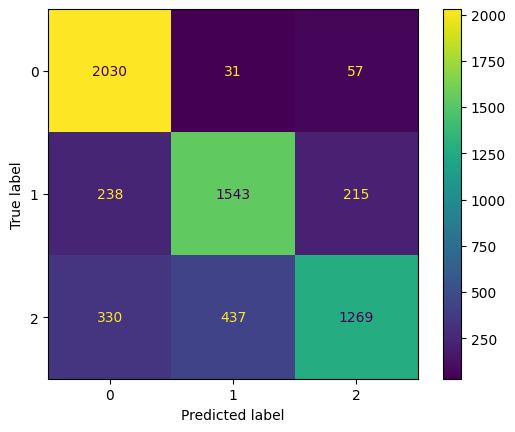

              precision    recall  f1-score   support

         0.0       0.78      0.96      0.86      2118
         1.0       0.77      0.77      0.77      1996
         2.0       0.82      0.62      0.71      2036

    accuracy                           0.79      6150
   macro avg       0.79      0.78      0.78      6150
weighted avg       0.79      0.79      0.78      6150



In [3]:
# Evaluate network on the full test set
ds = test_dl.dataset
net = net.reset_state()
output, _, _ = net(ds.x.numpy())
m = np.sum(output, axis=1)
preds = np.argmax(m, axis=1)
print(f"Final accuracy: {np.round(np.mean(np.array(preds == ds.y.numpy()))*100,decimals=2)}%")

# Calculate confusion matrix
cm = confusion_matrix(ds.y.numpy(), preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# Print the classification report
print(classification_report(ds.y.numpy(), preds))

Neural Activity (spikes per neuron): [0. 2. 1.]
Expected Label: 1
Predicted Label: 1


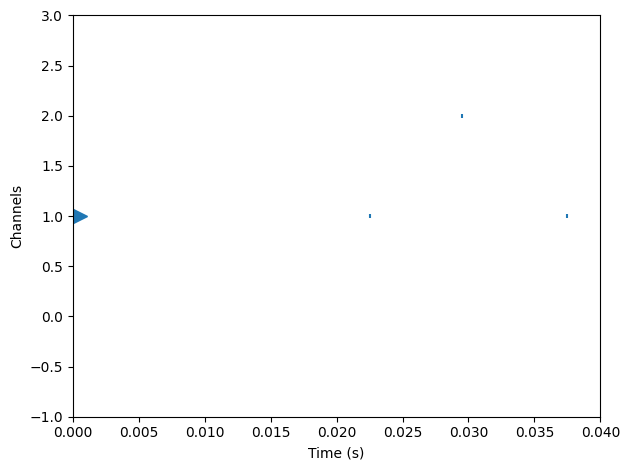

In [4]:
# Plot the network activity for a specific sample
ds = test_dl.dataset
i = 0
output, _, _ = net(ds.x.numpy()[i])

spks = np.sum(output,axis=1)[0]
print(f"Neural Activity (spikes per neuron): {spks}")
print(f"Expected Label: {int(ds.y.numpy()[i])}")
print(f"Predicted Label: {spks.argmax()}")

TSEvent.from_raster(
            output[0],
            dt=1e-3,
        ).plot(marker="|", s=8)
plt.plot(0, ds.y.numpy()[i], '>', ms=20)
plt.tight_layout()
plt.show()

# Hardware Config Mapping

In [5]:
# Convert network to spec
net_graph = net.as_graph()
spec = mapper(net_graph)

# Scale the weights to account for temperature discrepancy
iscale_value = 20
spec["Iscale"] *= iscale_value

# Quantise the parameters
spec.update(autoencoder_quantization(**spec))

# Convert spec to DYNAP-SE2 configuration
config = config_from_specification(**spec)

# Print the most significative parameters from hardware configuration object
enabled_params = ["SYAM_W0_P","SYAM_W1_P","SYAM_W2_P","SYAM_W3_P","DEAM_ITAU_P","DEAM_ETAU_P","DEAM_IGAIN_P","DEAM_EGAIN_P","SOIF_LEAK_N","SOIF_SPKTHR_P","SOIF_GAIN_N","SOIF_REFR_N","SOIF_DC_P"]

params = []
for (k,v) in config["config"].chips[0].cores[0].parameters.items():
    if k in enabled_params:
        params.append((k,v))

for param in sorted(params):
    print(f"{param[0]} -> (Coarse:{param[1].coarse_value}, Fine:{param[1].fine_value})")

# Build DYNAPSim from the config
net_quantized = dynapsim_net_from_config(**config)

# Remember, we scaled the Iscale previously, now we should take this back!
net_quantized[1].Iscale /= iscale_value

DEAM_EGAIN_P -> (Coarse:3, Fine:92)
DEAM_ETAU_P -> (Coarse:1, Fine:102)
DEAM_IGAIN_P -> (Coarse:0, Fine:0)
DEAM_ITAU_P -> (Coarse:5, Fine:255)
SOIF_DC_P -> (Coarse:0, Fine:4)
SOIF_GAIN_N -> (Coarse:0, Fine:71)
SOIF_LEAK_N -> (Coarse:0, Fine:22)
SOIF_REFR_N -> (Coarse:2, Fine:53)
SOIF_SPKTHR_P -> (Coarse:4, Fine:243)
SYAM_W0_P -> (Coarse:5, Fine:25)
SYAM_W1_P -> (Coarse:4, Fine:231)
SYAM_W2_P -> (Coarse:5, Fine:38)
SYAM_W3_P -> (Coarse:5, Fine:46)


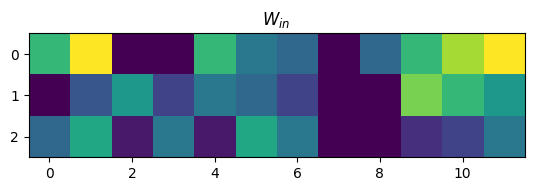

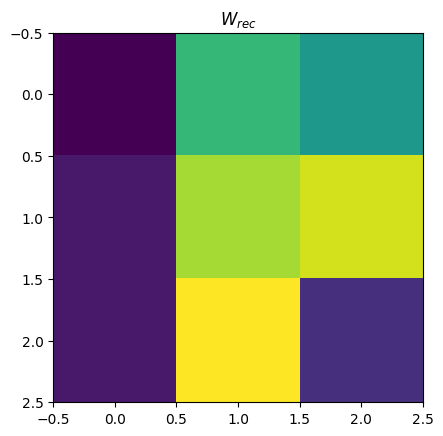

In [6]:
plt.imshow(np.array(spec['weights_in']).T)
plt.title('$W_{in}$')
plt.show()

plt.imshow(np.array(spec['weights_rec']).T)
plt.title('$W_{rec}$')
plt.show()

# Quantized Network Analysis

Final accuracy: 72.05%


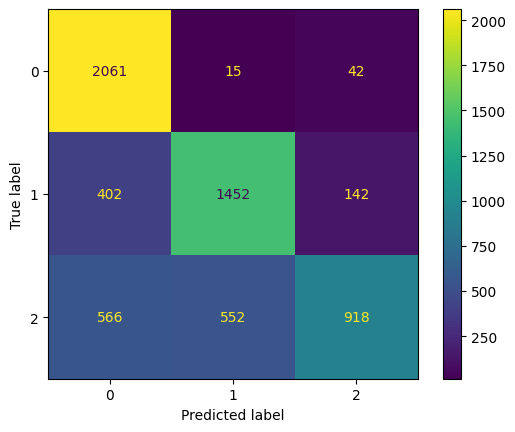

              precision    recall  f1-score   support

         0.0       0.68      0.97      0.80      2118
         1.0       0.72      0.73      0.72      1996
         2.0       0.83      0.45      0.59      2036

    accuracy                           0.72      6150
   macro avg       0.74      0.72      0.70      6150
weighted avg       0.74      0.72      0.70      6150



In [7]:
# Evaluate the DYNAPSim network on the full test set
ds = test_dl.dataset
net = net.reset_state()
output, _, _ = net_quantized(ds.x.numpy())
m = np.sum(output, axis=1)
preds = np.argmax(m, axis=1)
print(f"Final accuracy: {np.round(np.mean(np.array(preds == ds.y.numpy()))*100,decimals=2)}%")

# Calculate confusion matrix
cm = confusion_matrix(ds.y.numpy(), preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# Print the classification report
print(classification_report(ds.y.numpy(), preds))

Readout layer activity (spikes): [0. 2. 1.]
Label: 1
Prediction: 1


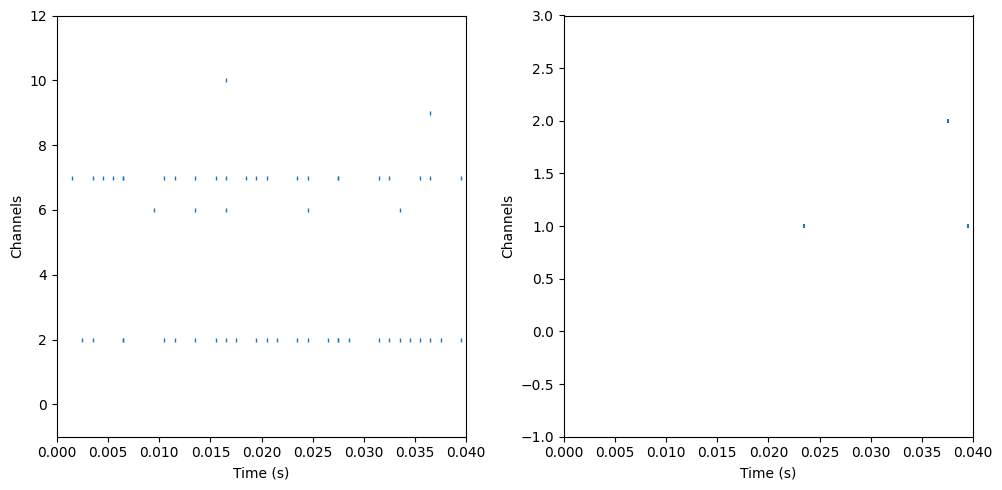

In [8]:
# Plot the DYNAPSim network activity for a specific sample
ds = test_dl.dataset
i = 0

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
TSEvent.from_raster(
            ds.x[i].numpy(),
            dt=1e-3,
        ).plot(marker="|", s=8,linewidths=1)

output, _, _ = net_quantized(ds.x[i].numpy())
spks = np.sum(output,axis=1)[0]
pred = np.argmax(spks)
print(f"Readout layer activity (spikes): {spks}")
print(f"Label: {int(ds.y[i].numpy())}")
print(f"Prediction: {pred}")

plt.subplot(1,3,2)
TSEvent.from_raster(
            output[0],
            dt=1e-3,
        ).plot(marker="|", s=8)

plt.tight_layout()
plt.show()

# DYNAP-SE2 Hardware Deploy

In [20]:
se2_devices = find_dynapse_boards()
if len(se2_devices) < 0:
    raise "No devices found..."

best_config = None
min_act = 1e10
max_spks = 0
for i_scale_value in range(1,30,2):

    spec = mapper(net_graph)

    # Scale the weights to account for temperature discrepancy
    spec["Iscale"] *= iscale_value

    # Quantise the parameters
    spec.update(autoencoder_quantization(**spec))

    # Convert spec to DYNAP-SE2 configuration
    config = config_from_specification(**spec)

    # Test activity
    se2 = DynapseSamna(se2_devices[0], **config,dt=1e-3)
    se2.discharge_capacitors()
    time.sleep(1)
    output, _, _ = se2(ds.x[1].numpy(), record=False)
    spks = np.sum(output[:,0:n_output_channels],axis=0)
    
    print(f"Test iscale_value:{i_scale_value} -> Spikes {spks}")
    label = int(ds.y[1].numpy())
    if len(spks) >= n_output_channels and (spks[label]> max_spks or spks[label] == max_spks and sum(spks) < min_act):
        max_spks = spks[label]
        min_act = sum(spks)
        best_config = config
        print(f"New best: {spks}")
    

# Print the most significative parameters from hardware configuration object
print("\nParameters:")
enabled_params = ["SYAM_W0_P","SYAM_W1_P","SYAM_W2_P","SYAM_W3_P","DEAM_ITAU_P","DEAM_ETAU_P","DEAM_IGAIN_P","DEAM_EGAIN_P","SOIF_LEAK_N","SOIF_SPKTHR_P","SOIF_GAIN_N","SOIF_REFR_N","SOIF_DC_P"]

params = []
for (k,v) in best_config["config"].chips[0].cores[0].parameters.items():
    if k in enabled_params:
        params.append((k,v))

for param in sorted(params):
    print(f"{param[0]} -> (Coarse:{param[1].coarse_value}, Fine:{param[1].fine_value})")

Test iscale_value:1 -> Spikes [3. 3. 5.]
New best: [3. 3. 5.]
Test iscale_value:3 -> Spikes [ 3.  5. 11.]
New best: [ 3.  5. 11.]
Test iscale_value:5 -> Spikes [2. 7. 5.]
New best: [2. 7. 5.]
Test iscale_value:7 -> Spikes [ 1. 11. 11.]
New best: [ 1. 11. 11.]
Test iscale_value:9 -> Spikes [ 3.  2. 11.]
Test iscale_value:11 -> Spikes [ 4. 11. 11.]
Test iscale_value:13 -> Spikes [ 3.  5. 11.]
Test iscale_value:15 -> Spikes [4.]
Test iscale_value:17 -> Spikes [4. 4. 3.]
Test iscale_value:19 -> Spikes [5. 2. 2.]
Test iscale_value:21 -> Spikes [1. 7. 5.]
Test iscale_value:23 -> Spikes [4.]
Test iscale_value:25 -> Spikes [ 4.  3. 12.]
Test iscale_value:27 -> Spikes [3. 2. 2.]
Test iscale_value:29 -> Spikes [5. 3. 3.]

Parameters:
DEAM_EGAIN_P -> (Coarse:3, Fine:92)
DEAM_ETAU_P -> (Coarse:1, Fine:102)
DEAM_IGAIN_P -> (Coarse:0, Fine:0)
DEAM_ITAU_P -> (Coarse:5, Fine:255)
SOIF_DC_P -> (Coarse:0, Fine:4)
SOIF_GAIN_N -> (Coarse:0, Fine:71)
SOIF_LEAK_N -> (Coarse:0, Fine:22)
SOIF_REFR_N -> (Coars

In [21]:
se2 = DynapseSamna(se2_devices[0], **best_config,dt=1e-3)

Readout layer activity (spikes): [10. 10. 10.]
Label: 2
Prediction: 0


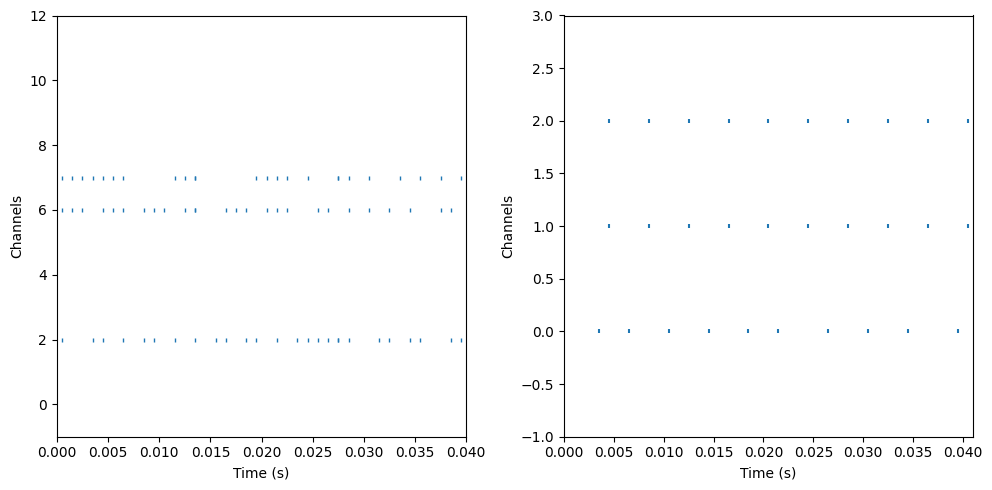

Readout layer activity (spikes): [8. 6. 2.]
Label: 0
Prediction: 0


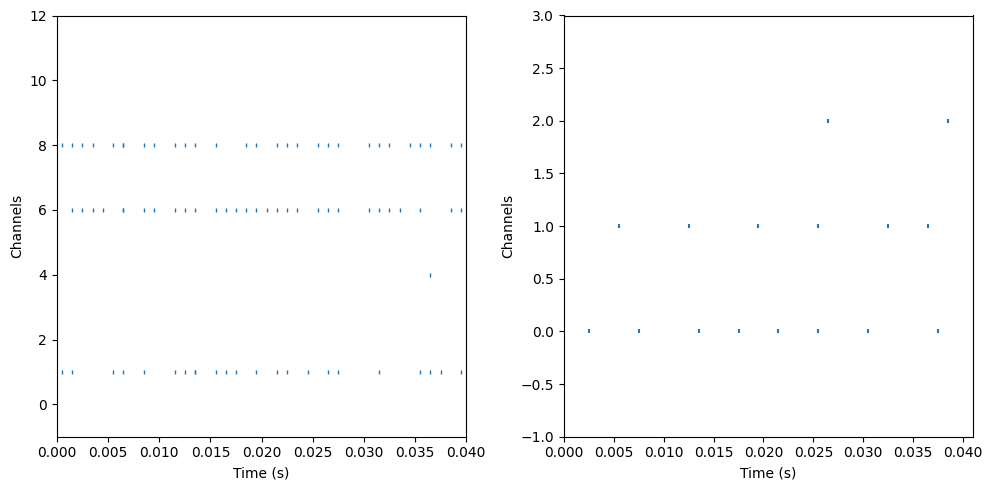

Readout layer activity (spikes): [ 2.  8. 11.]
Label: 1
Prediction: 2


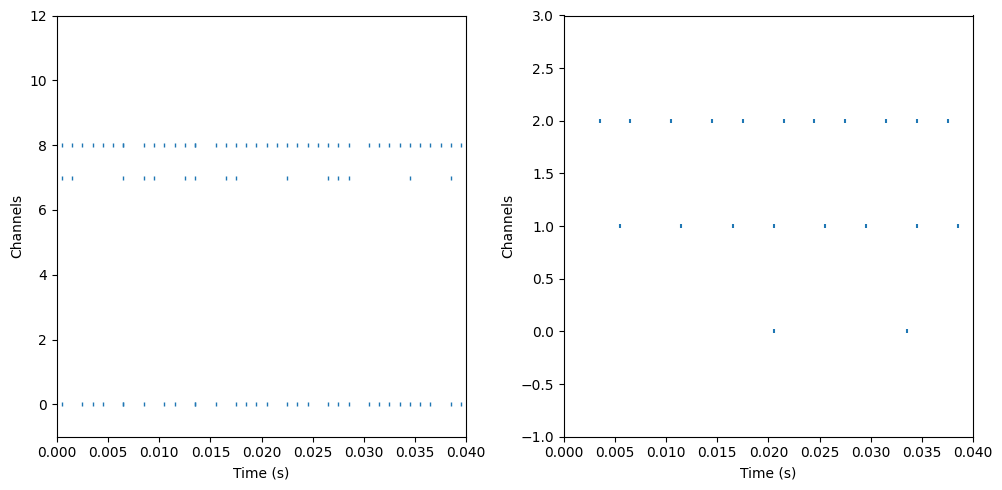

Readout layer activity (spikes): [11.  1.  9.]
Label: 0
Prediction: 0


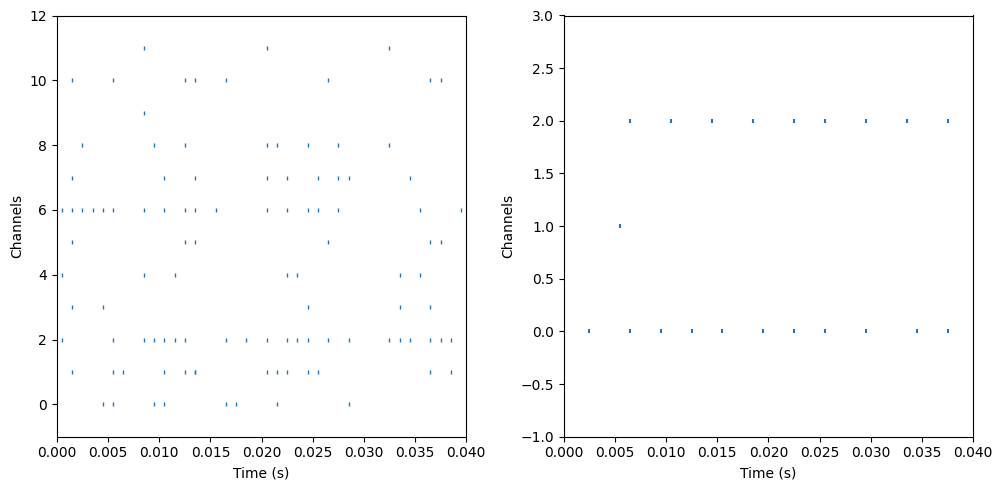

Readout layer activity (spikes): [ 6. 10. 10.]
Label: 1
Prediction: 1


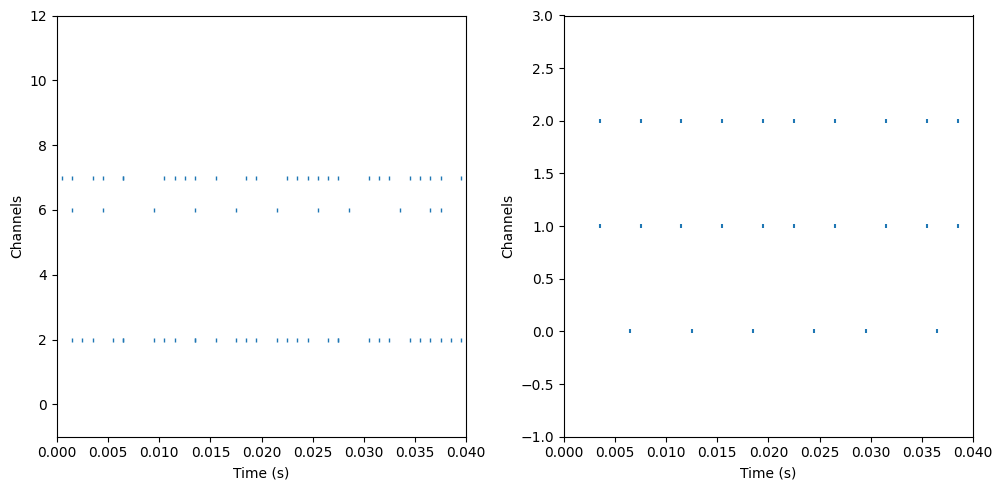

Readout layer activity (spikes): [9. 5. 5.]
Label: 2
Prediction: 0


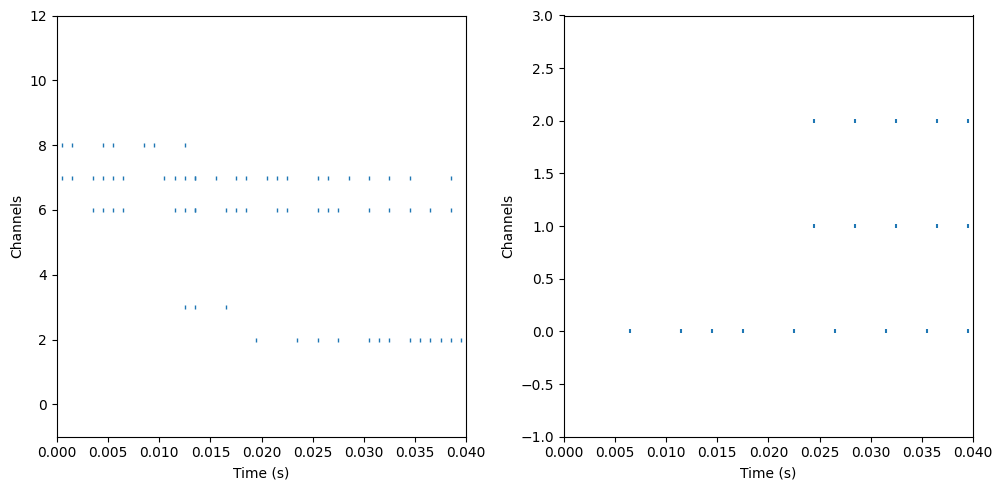

Readout layer activity (spikes): [ 8. 10. 10.]
Label: 1
Prediction: 1


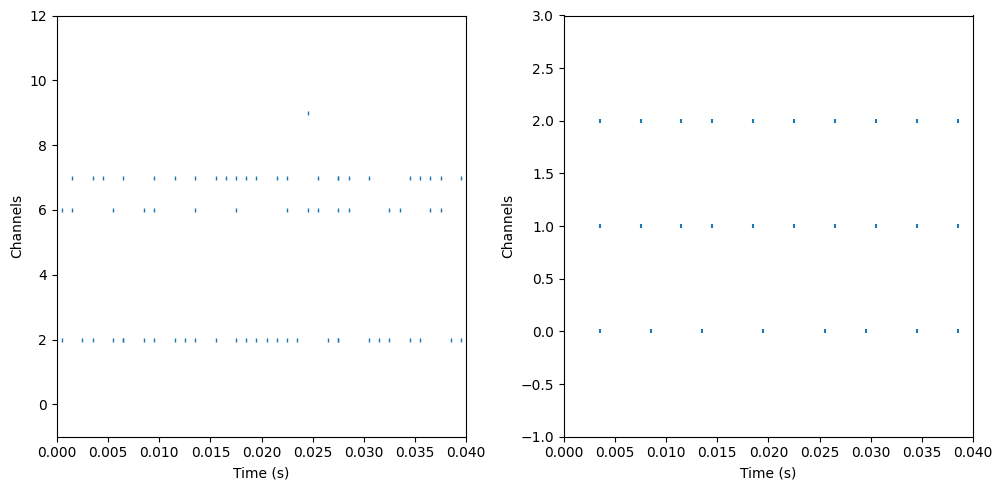

Readout layer activity (spikes): [ 9.  5. 12.]
Label: 0
Prediction: 2


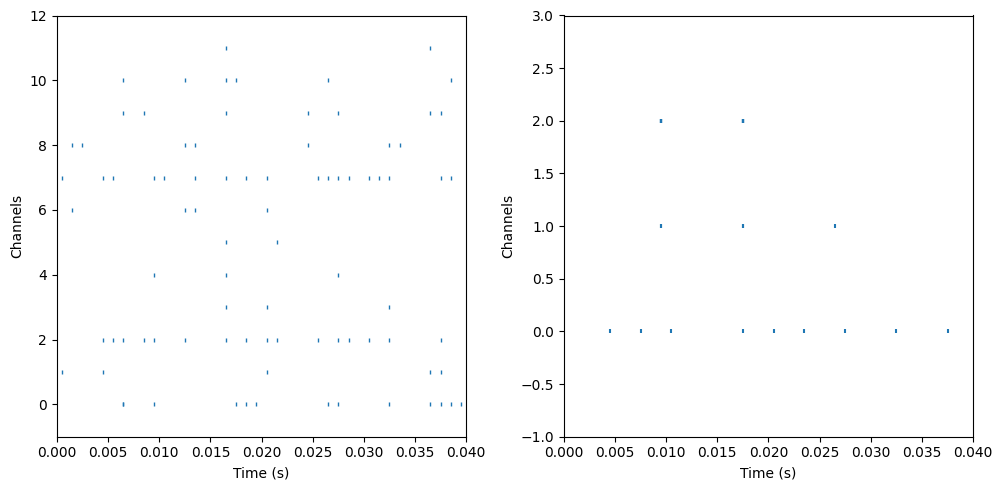

Readout layer activity (spikes): [10. 10. 10.]
Label: 1
Prediction: 0


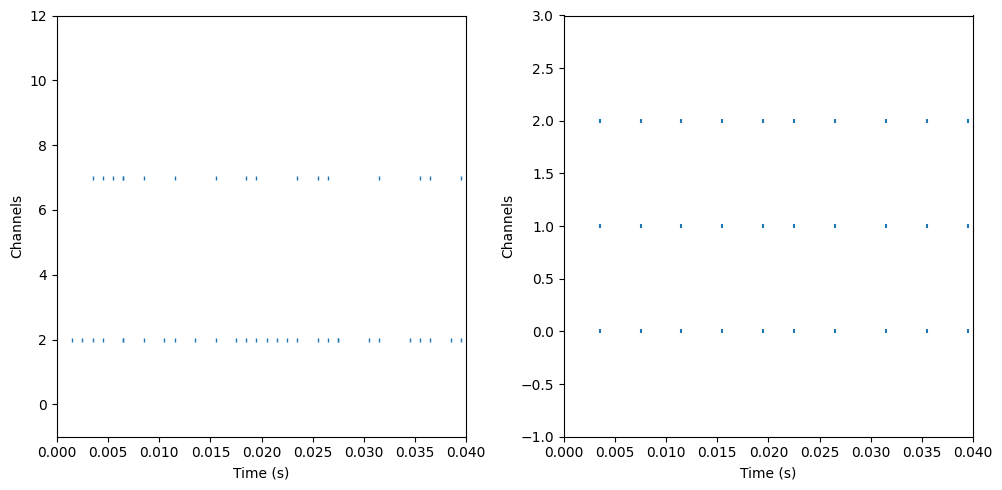

Readout layer activity (spikes): [11. 11. 11.]
Label: 1
Prediction: 0


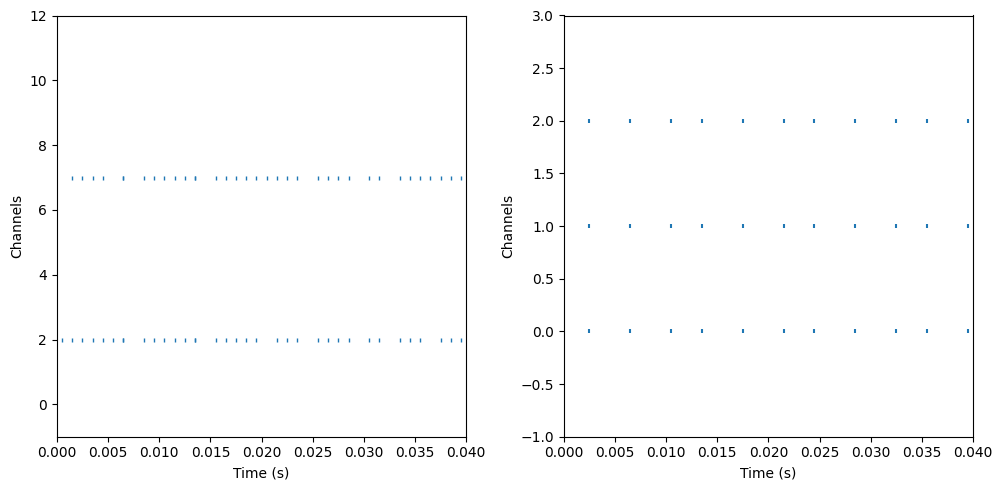

Readout layer activity (spikes): [5. 1. 9.]
Label: 0
Prediction: 2


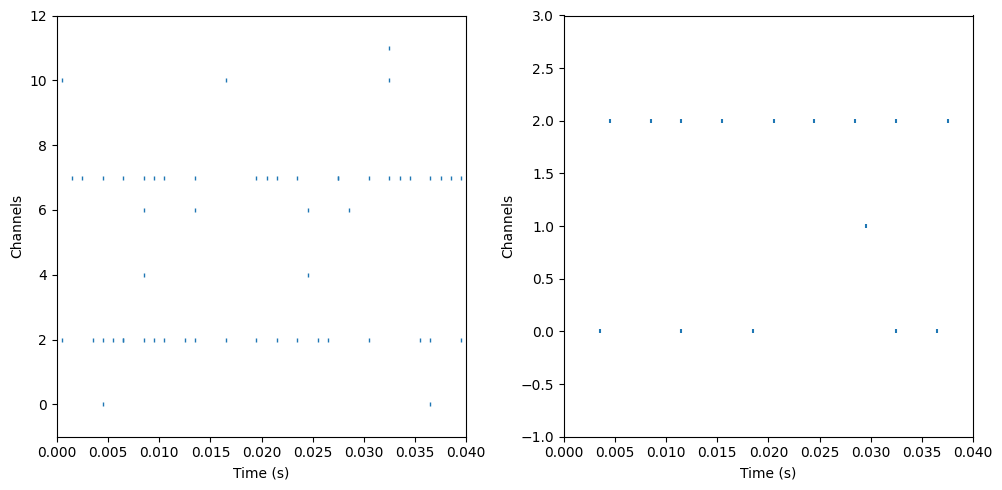

Readout layer activity (spikes): [1. 5. 9.]
Label: 2
Prediction: 2


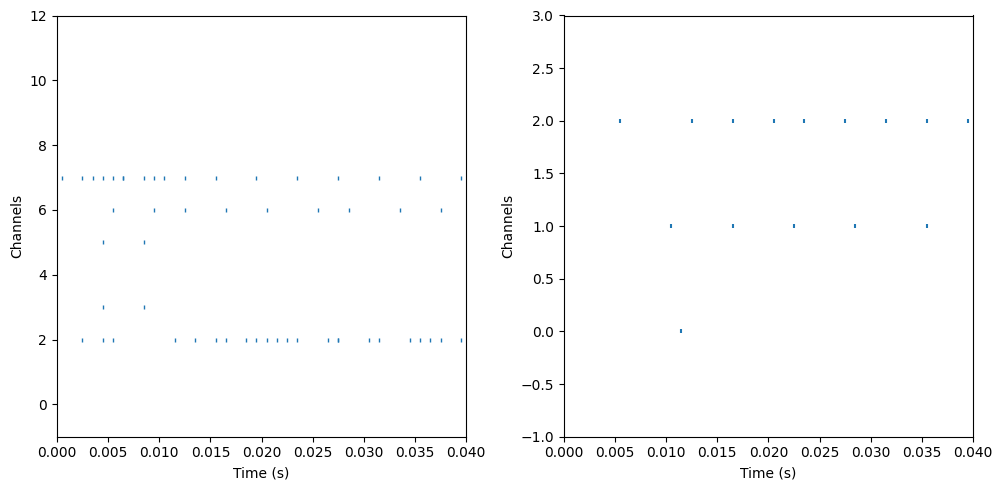

Readout layer activity (spikes): [ 2.  1. 21.]
Label: 2
Prediction: 2


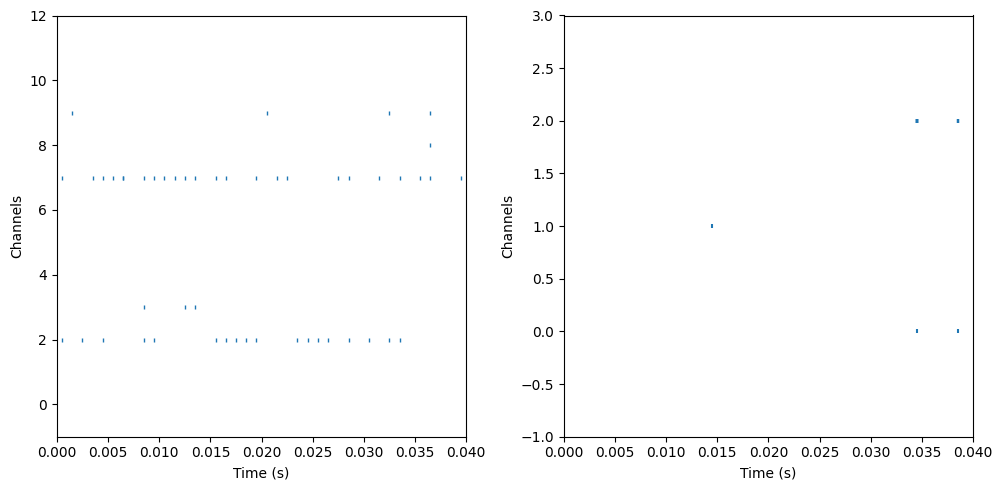

Readout layer activity (spikes): [10.  3.  6.]
Label: 0
Prediction: 0


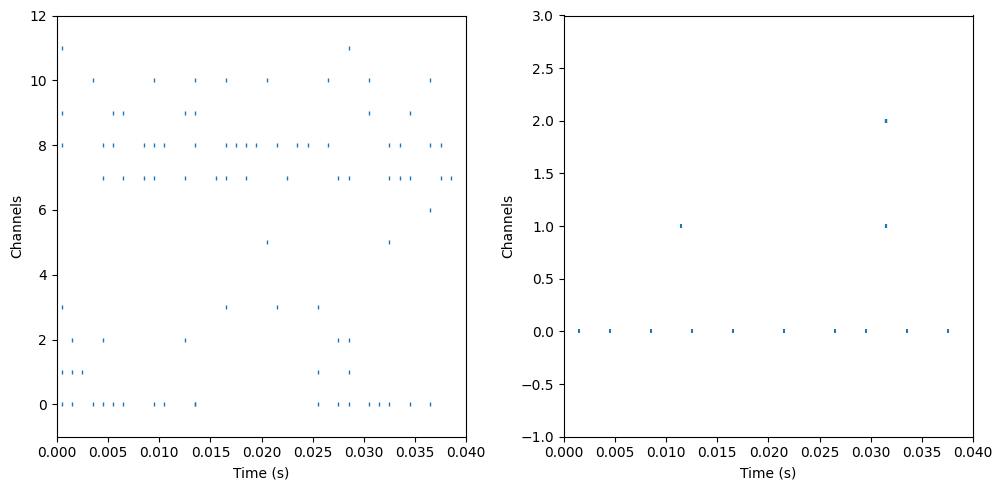

Readout layer activity (spikes): [11.  3.  6.]
Label: 0
Prediction: 0


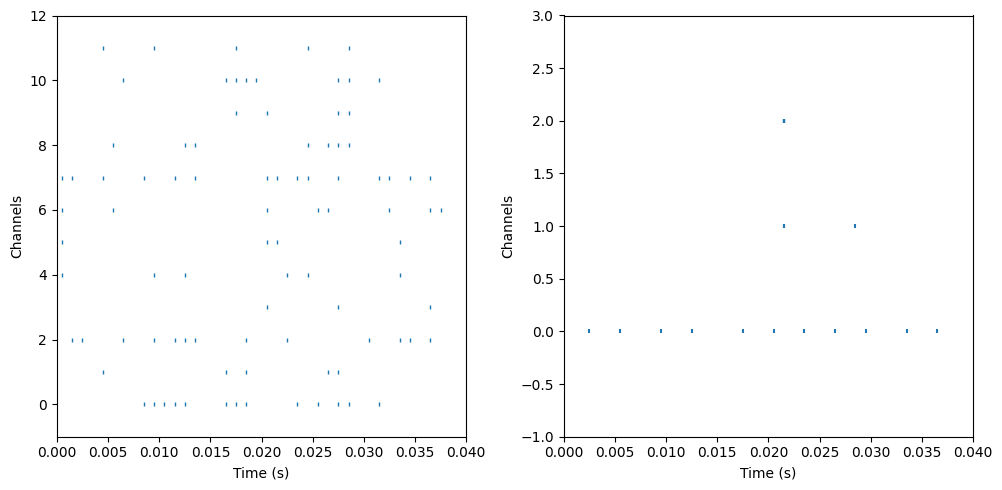

Readout layer activity (spikes): [6. 9. 9.]
Label: 2
Prediction: 1


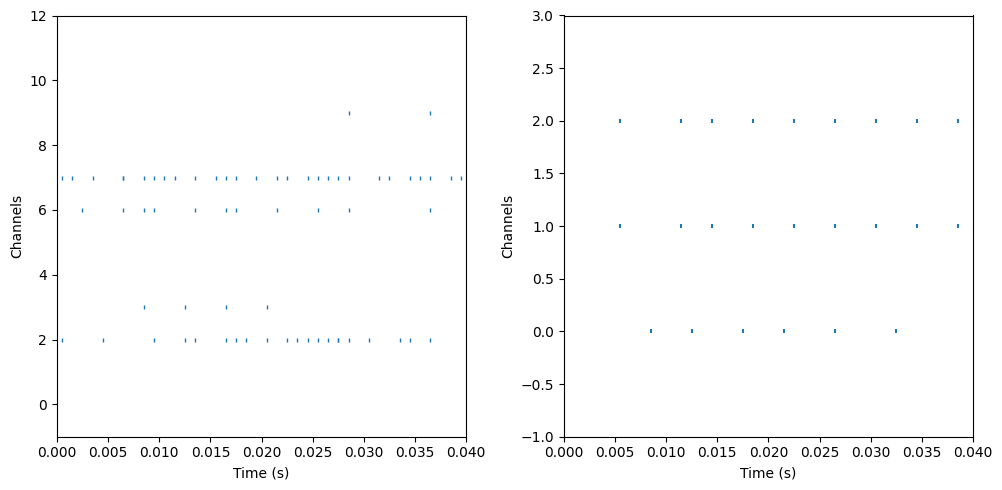

Readout layer activity (spikes): [3. 3. 7.]
Label: 0
Prediction: 2


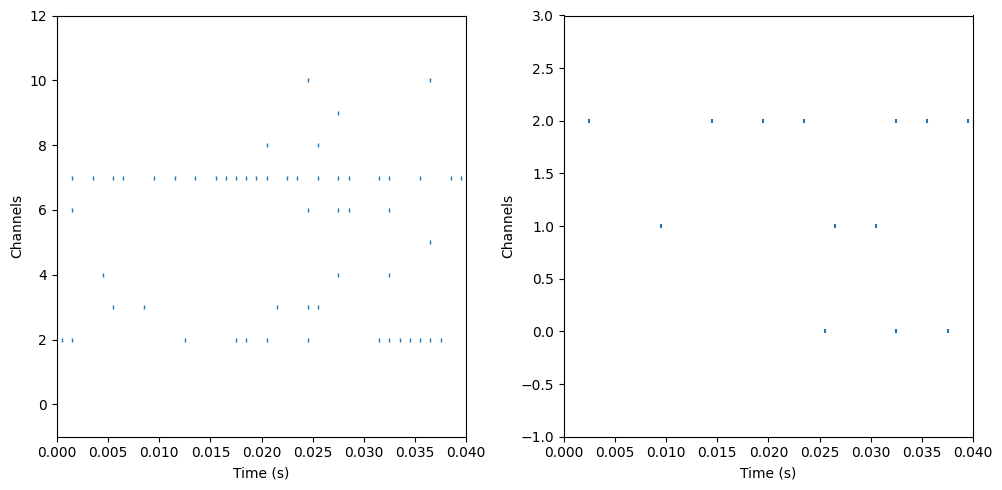

Readout layer activity (spikes): [13.  2. 14.]
Label: 2
Prediction: 2


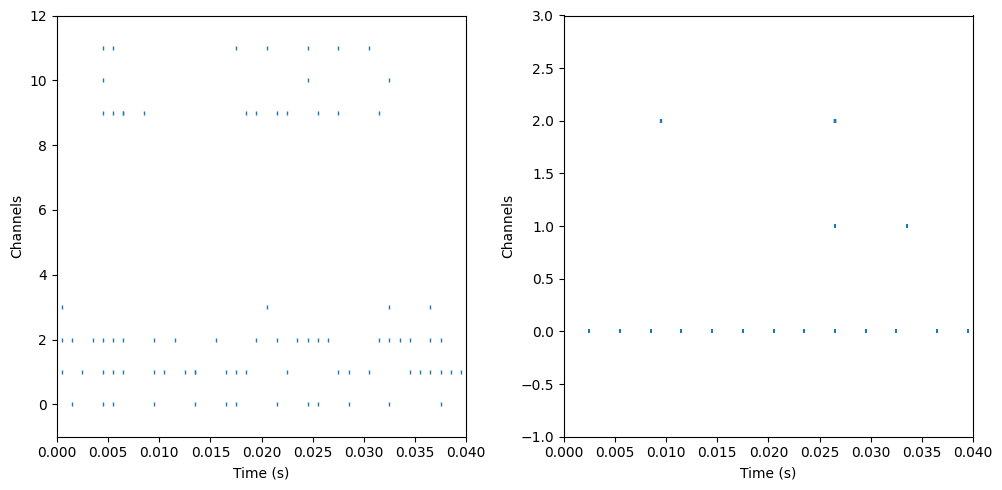

Readout layer activity (spikes): [0. 0. 0.]
Label: 0
Prediction: 0


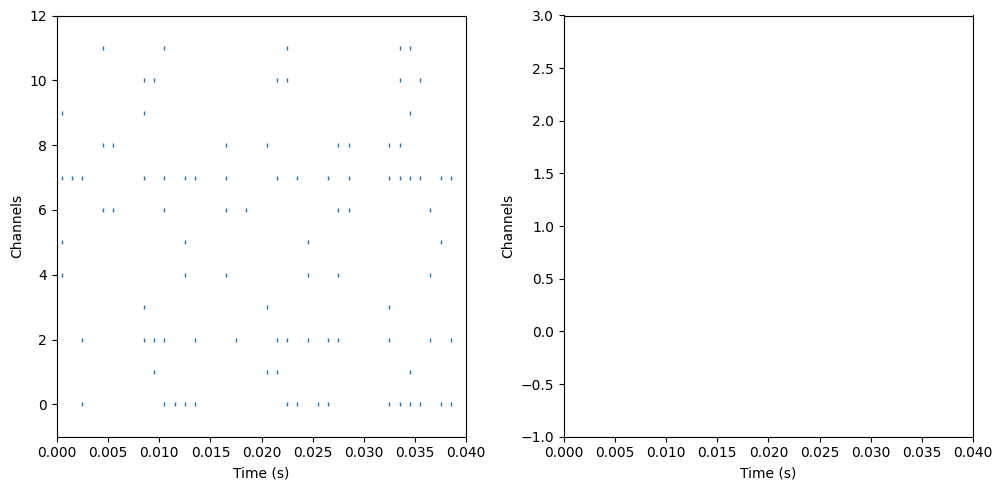

Readout layer activity (spikes): [ 9. 10. 10.]
Label: 1
Prediction: 1


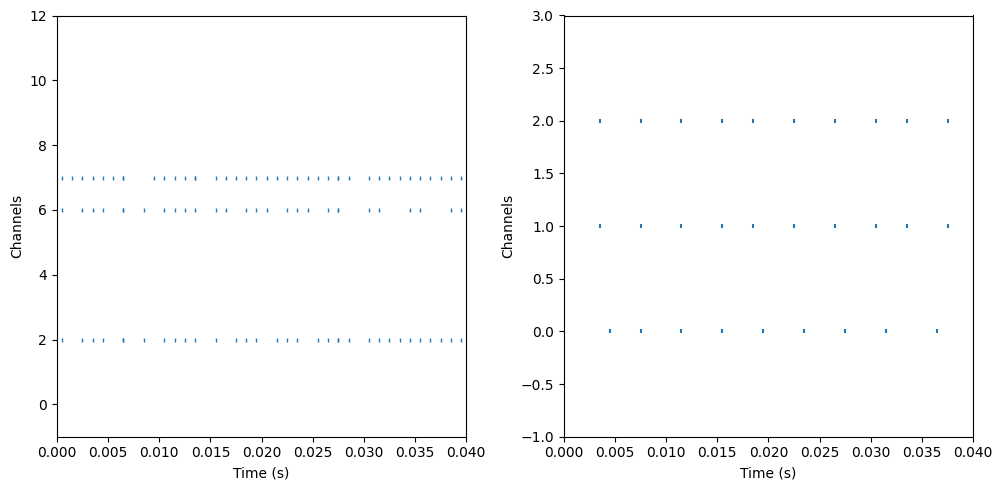

Final accuracy: 55.00000000000001%
[2. 0. 1. 0. 1. 2. 1. 0. 1. 1. 0. 2. 2. 0. 0. 2. 0. 2. 0. 1.]
[0 0 2 0 1 0 1 2 0 0 2 2 2 0 0 1 2 2 0 1]
              precision    recall  f1-score   support

         0.0       0.56      0.62      0.59         8
         1.0       0.75      0.50      0.60         6
         2.0       0.43      0.50      0.46         6

    accuracy                           0.55        20
   macro avg       0.58      0.54      0.55        20
weighted avg       0.58      0.55      0.55        20



In [22]:

ds = test_dl.dataset
preds = []
activity = []
sample_subset = (100,120)
for i in range(*sample_subset):
    time.sleep(1)
    se2.discharge_capacitors()
    time.sleep(1)
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    TSEvent.from_raster(
                ds.x[i].numpy(),
                dt=1e-3,
            ).plot(marker="|", s=8,linewidths=1)

    output, state, rec = se2(ds.x[i].numpy(), record=False)

    spks = np.sum(output[:,0:n_output_channels],axis=0)
    pred = None
    if output.shape[1] > 0:
        pred = np.argmax(spks)
    preds.append(pred)
    activity.append(output)
    print(f"Readout layer activity (spikes): {spks}")
    print(f"Label: {int(ds.y[i].numpy())}")
    print(f"Prediction: {pred}")

    plt.subplot(1,3,2)
    TSEvent.from_raster(
                output[:,0:n_output_channels],
                dt=1e-3,
            ).plot(marker="|", s=8)
    
    plt.tight_layout()
    plt.show()

preds = np.array(preds)
print(f"Final accuracy: {np.mean(preds[preds != None]==ds.y.numpy()[sample_subset[0]:sample_subset[1]][preds!=None])*100}%")
with open(f"{model_path}/recorded_activity.pkl", 'wb') as f:
    pickle.dump(activity, f, pickle.HIGHEST_PROTOCOL)
# Print the classification report
print(ds.y.numpy()[sample_subset[0]:sample_subset[1]][preds!=None])
print(preds[preds != None])
print(classification_report(ds.y.numpy()[sample_subset[0]:sample_subset[1]][preds!=None], preds[preds != None]))

In [ ]:
# Samna 0.27.16.0
# Rockpool 2.6.dev0    /Users/marcobramini/Code/rockpool